### Validating the optical depth and cooling rates in Titan's atmosphere

In [47]:
# load dependencies
from titan_data import *
    
##################################################################################################################
######################################### RUN RFM FOR TITAN  #####################################################
##################################################################################################################

# Step 0: Define the case and the resolution
class parameters:
    def __init__(self,**params):
        # Spectral resolution used in RFM experiments
        self.nu0 = params.get('nu0', 1)  # cm-1
        self.nu1 = params.get('nu1', 3000)  # cm-1
        self.dnu = params.get('dnu', 0.1)  # cm-1
        self.band = params.get('band', 'titan')
        self.runtype = params.get('runtype', 'cooling')
        self.cpdef = params.get('cp', 29012 / 28.964)  # J/kg/K (default RFM value of specific heat)
        self.nsday = params.get('nsday', 86400)  # seconds per Earth-day
        self.TEMREL = params.get('TEMREL', 0)  # ground-air temp diff.

        # spectral range calculations
        self.nus = np.arange(self.nu0, self.nu1 + self.dnu, self.dnu)
        if self.band == 'titan':
            self.i0 = np.squeeze(np.where(np.abs(self.nus - self.nu0) == np.min(np.abs(self.nus - self.nu0))))
            self.i1 = np.squeeze(np.where(np.abs(self.nus - self.nu1) == np.min(np.abs(self.nus - self.nu1))))
        self.nnus = len(self.nus)

        # Thermodynamic parameters
        self.ps = params.get('ps', 1.5e5)
        self.Ts = params.get('Ts', 93)
        self.Ttrp = params.get('Ttrp', 71)
        self.Gamma = params.get('Gamma', 0.55e-3)
        self.z = params.get('z', np.arange(0, 5e4, 1))

        # Additional thermodynamic parameters
        self.Ttrip = params.get('Ttrip', 90.68)  # K 
        self.ptrip = params.get('ptrip', 11700.) # Pa
        self.E0v   = params.get('E0v', 4.9e5)      # J/kg 
        self.ggr   = params.get('ggr', 1.35)       # m/s^2, gravity
        self.rgasa = params.get('rgasa', 296.8)  # J/kg/K, specific gas constant of dry air
        self.rgasv = params.get('rgasv', 518.28) # J/kg/K, specific gas constant of methane vapor
        self.cva   = params.get('cva', 707.2)      # J/kg/K, isovolumetric specific heat of dry air
        self.cvv   = params.get('cvv', 1707.4)     # J/kg/K, isovolumetric specific heat of methane vapor
        self.cvl   = params.get('cvl', 3381.55)    # J/kg/K, isovolumetric specific heat of liquid methane
        self.cpa   = params.get('cpa', self.cva + self.rgasa)  # isobaric specific heat of dry air
        self.cpv   = params.get('cpv', self.cvv + self.rgasv)  # isobaric specific heat of methane vapor
        self.eps   = params.get('eps', self.rgasa / self.rgasv) # ratio of specific gas constants
        self.L     = params.get('L', 5.5e5)          # enthalpy of vaporization of methane
        self.E0s   = params.get('E0s', np.nan)     # no ice phase
        self.cvs   = params.get('cvs', np.nan)     # no ice phase
        
        self.cpvmol_H2  = params.get('cpvmol_H2', 25)   # isobaric specific heat of hydrogen gas (H2) at 90 K at 1 atm (J/K/mol)
        self.cpvmol_N2  = params.get('cpvmol_N2', 29.125)  # isobaric specific heat of nitrogen gas (N2) at 90 K at 1 atm (J/K/mol)
        self.cpvmol_CH4 = params.get('cpvmol_CH4',34)   # isobaric specific heat of methane gas (CH4) at 90 K at 1 atm (J/K/mol)
        
        # Titan-like composition parameters
        self.xH2   = params.get('xH2',0.001)  # molar mixing ratio of hydrogen (0.1%)
        self.MN2   = params.get('MN2',2*14.01*1e-3)  # molecular weight of N2 (kg/mol)
        self.MCH4  = params.get('MCH4',(12.01+4*1.008)*1e-3) # molecular weight of CH4 (kg/mol)
        self.MH2   = params.get('MH2',2*1.008*1e-3)  # molecular weight of H2 (kg/mol)
        self.Runi  = params.get('Runi',8.314) # universal gas constant (J/mol/K)
        self.RN2   = params.get('RN2',self.Runi/self.MN2) # specific gas constant of N2 (J/kg/K)
        self.RCH4  = params.get('RCH4',self.Runi/self.MCH4) # specific gas constant of CH4 (J/kg/K)
        self.RH2   = params.get('RH2',self.Runi/self.MH2) # specific gas constant of H2 (J/kg/K)
        
        # Initialize case string
        self.case = ""
        
    def generate_case(self,**params):
        planet       = params.get('planet','unknown')
        self.RHs     = params.get('RHs',0.75)
        self.RHmid   = params.get('RHmid',0.54)
        self.RHtrp   = params.get('RHtrp',0.75)
        self.Tmid    = params.get('Tmid',82)
        self.uniform = params.get('uniform',1)
        # Extract gases dynamically (gas1, gas2, ..., gasN)
        gases = [params[key] for key in sorted(params) if key.startswith('gas')]
        # Define valid CIA pairs as tuples for safety with multi-character molecules
        self.valid_ciapairs = params.get('valid_ciapairs', [('N2', 'N2'), ('N2', 'CH4'), ('N2', 'H2'), ('CH4', 'CH4')])
        # Filter CIA pairs to include only those with gases in the `gases` list
        ciapairs = [
            f"{mol1}{mol2}" for (mol1, mol2) in self.valid_ciapairs
            if mol1 in gases and mol2 in gases
        ]
        # Format the CIA part of the case name
        cia_str = "-CIA-" + "-".join(ciapairs) if ciapairs else ""
        # Construct the case name
        self.case = '-'.join([
            planet,
            *gases,
            str(int(self.RHmid * 100)),
            str(self.Tmid),
            str(self.uniform)
        ]) + cia_str
        print('generate_case: ',self.case)
        
def get_odepth_local(par)->dict[str,float]:
    #############################################################
    # Unpack the inputs
    heights = np.arange(0,50e3,1e2)
    #############################################################
    # odepth uses an internal decision for crdnu
    crdnu = 40 # cm-1
    #############################################################
    srtau    = []  # spectrally-resolved optical depth at each height (levs,nus)
    zsrtau1  = []  # tau=1 heights as a function of nu (nus)
    #D        = 1.5 # two-stream diffusivity factor
    fdir     = rfmtools.utils.RFM_DIR+'/outp/%s'%par.case
    for height in heights:
        if height<100:
            df = '%s/opt_0000%i.asc' %(fdir,height)
        elif height<1000:
            df = '%s/opt_00%i.asc' %(fdir,height)
        elif height<10000:
            df = '%s/opt_0%i.asc' %(fdir,height)
        else:
            df = '%s/opt_%i.asc' %(fdir,height)
        # append spect-res. tau at each height
        srtau.append(np.loadtxt(df,skiprows=4))   
    #srtau = D*np.array(srtau)
    srtau  = np.array(srtau)
    
    # retain information from the spectral band
    srtau   = srtau[:,par.i0:par.i1+1]
        
    # Compute linear averages over coarse 10 cm-1 bins
    crnus     = np.arange(par.nu0+crdnu/2,par.nu1+crdnu/2,crdnu)
    bin_edges = np.arange(par.nu0,par.nu1+crdnu,crdnu)
    bin_means,bin_edges,binnumber = scipy.stats.binned_statistic(par.nus[par.i0:par.i1+1], srtau, statistic='mean', bins=bin_edges)
    crsrtau   = bin_means
    return {'srtau':srtau,'crnus':crnus,'crsrtau':crsrtau}

def get_hr_local(par):
    #############################################################
    # Unpack the inputs
    heights = np.arange(0,50e3,1e2)
    #############################################################
    srhr = [] # spectrally-resolved heating rate at each height (levs,nus)
    hr   = [] # spectrally-integ.   heating rate at each height (levs)
    fdir = '/home/fspauldinga/SAM24a/RFM/outp/%s'%par.case
    for height in heights:
        if height<100:
            df = '%s/coo_0000%i.asc' %(fdir,height)
        elif height<1000:
            df = '%s/coo_00%i.asc' %(fdir,height)
        elif height<10000:
            df = '%s/coo_0%i.asc' %(fdir,height)
        else:
            df = '%s/coo_%i.asc' %(fdir,height)
        # append spect-res. hr at each height
        srhr.append(np.loadtxt(df,skiprows=4))   
    srhr = np.array(srhr)    
    
    # Retain only the band information
    srhr = srhr[:,par.i0:par.i1+1] 
    
    # Calculate the band-integrated cooling rate (K/day)
    hr.append(par.dnu*np.sum(srhr,axis=1)) 
    hr = np.squeeze(np.array(hr))
    return {'hr':hr,'srhr':srhr} 


def load_pickle(filename):
    try:
        with open(filename, 'rb') as file:
            data = pickle.load(file)
        print(f"Successfully loaded data from {filename}")
        return data
    except FileNotFoundError:
        print(f"Error: The file '{filename}' was not found.")
    except pickle.UnpicklingError:
        print(f"Error: Failed to load the pickle file '{filename}'. It may be corrupted.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

### Surface optical depth using CIA absorption of the following constituents: 
(1) All gases with N2-N2 CIA only <br>
(2) All gases with N2-CH4 CIA only <br>
(3) All gases with N2-H2 CIA only <br>
(4) All gases with CH4-CH4 CIA only <br>
(5) All gases with all CIA pairs: [('N2', 'N2'), ('N2', 'CH4'), ('N2', 'H2'), ('CH4', 'CH4')]  <br>

The cooling rates (K/day) in RFM are calculated as follows:

$R = d( Fu - Fd)/dz × 1/(C_p × ρ) × 86400$

Since we set $C_p = 29012.0$ J/K/kmol for the heat capacity of air, we need to multiply the cooling rate by $C_p$ and then divide by the true $c_p = \sum x_i c_{p,i}$, where $x_i$ is the molar mixing ratio of constituent $i$.

generate_case:  titan-N2-CH4-H2-54-82-1-CIA-N2N2
Successfully loaded data from titan-N2-CH4-H2-54-82-1-CIA-N2N2.pickle
generate_case:  titan-N2-CH4-H2-54-82-1-CIA-N2CH4
Successfully loaded data from titan-N2-CH4-H2-54-82-1-CIA-N2CH4.pickle
generate_case:  titan-N2-CH4-H2-54-82-1-CIA-N2H2
Successfully loaded data from titan-N2-CH4-H2-54-82-1-CIA-N2H2.pickle
generate_case:  titan-N2-CH4-H2-54-82-1-CIA-CH4CH4
Successfully loaded data from titan-N2-CH4-H2-54-82-1-CIA-CH4CH4.pickle
generate_case:  titan-N2-CH4-H2-54-82-1-CIA-N2N2-N2CH4-N2H2-CH4CH4
Successfully loaded data from titan-N2-CH4-H2-54-82-1-CIA-N2N2-N2CH4-N2H2-CH4CH4.pickle
generate_case:  titan-N2-CH4-H2-54-82-1
Successfully loaded data from titan-N2-CH4-H2-54-82-1.pickle


Text(0, 0.5, 'height [km]')

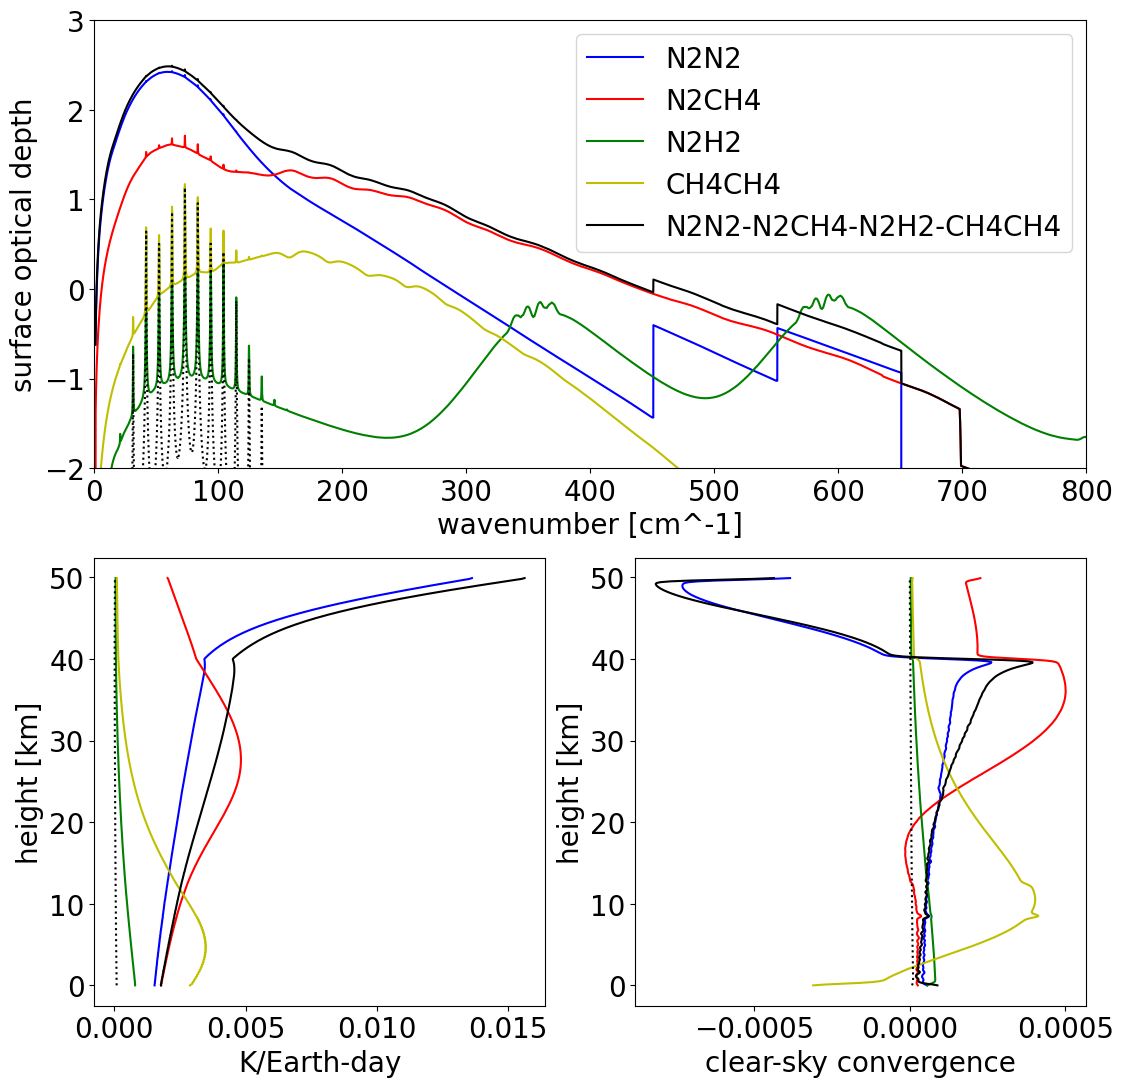

In [60]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from labellines import labelLine
import scipy
from scipy.ndimage import gaussian_filter1d
# Create the figure
fig = plt.figure(figsize=(2*dim, 2*dim))
# Define the GridSpec with 2 rows and 2 columns
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])
# Top plot spans both columns
ax1 = fig.add_subplot(gs[0, :])  # First row, all columns
# Bottom row has two separate plots
ax2 = fig.add_subplot(gs[1, 0])  # Second row, first column
ax3 = fig.add_subplot(gs[1, 1])  # Second row, second column

######################################################################################################
# specify what gases to include (can control valid CIA pairs in generate_case)
gases    = ['N2','CH4','H2']
ciapairs = [('N2', 'N2')]

# dynamically create an argument dictionary
def generate_args(planet, gases, ciapairs, **relhum):
    return {'planet': planet, **{f'gas{i+1}': gas for i, gas in enumerate(gases)}, 'valid_ciapairs': ciapairs, **relhum}
args = generate_args('titan', gases, ciapairs, RHs=0.75, RHmid=0.54, RHtrp=0.75, uniform=1)
        
# create a class instance and generate an RFM case from argument dictionary
par = parameters()
par.generate_case(**args)

# spectrally-resolved coarse-resolution optical depth at the surface
dat     = get_odepth_local(par)
crsrtau = np.log10(dat['srtau'][0,:]) # (levs,nus)
crnus   = par.nus
line    = ax1.plot(crnus,crsrtau,color='b',label='-'.join([''.join(pair) for pair in ciapairs]))
labelLine(line[0], x=2500, 
          label='-'.join([''.join(pair) for pair in ciapairs]), 
          align=True)

# load the thermodynamic profiles
dataset = load_pickle(f"{par.case}.pickle")
cpvmol  = (par.cpvmol_N2*dataset['RFM']['xN2']  # isobaric molar specific heat of air (J/K/mol) 
           + par.cpvmol_CH4*dataset['RFM']['xCH4'] 
           + par.cpvmol_H2*dataset['RFM']['xH2']) 
corrective_factor = 29.012/cpvmol # (J/K/mol)/(J/K/mol)
# Cooling rate (K/Earth-day)
dat     = get_hr_local(par)
hr      = dat['hr']*corrective_factor
line    = ax2.plot(hr,dataset['RFM']['z']/1e3,color='b',label='-'.join([''.join(pair) for pair in ciapairs]))

# Clear-sky convergence (1/day)
dTdt    = hr/par.nsday # K/Earth-day => K/s
rhomol  = dataset['RFM']['p']/(par.Runi*dataset['RFM']['T']) # molar density via ideal gas law (mol/m3) = p/(RT), where R is universal gas constant
H       = rhomol*cpvmol*dTdt # W/m3
sigma   = (par.ggr/par.cpa)-dataset['RFM']['Gamma'] # Gammad-Gamma (K/m)
CSC     = -np.gradient(H,dataset['RFM']['z'])/(cpvmol*rhomol*sigma)
CSC     = gaussian_filter1d(CSC, sigma=2)
line    = ax3.plot(CSC*par.nsday,dataset['RFM']['z']/1e3,color='b',label='-'.join([''.join(pair) for pair in ciapairs]))

######################################################################################################
# specify what gases to include (can control valid CIA pairs in generate_case)
gases    = ['N2','CH4','H2']
ciapairs = [('N2', 'CH4')]

# dynamically create an argument dictionary
def generate_args(planet, gases, ciapairs, **relhum):
    return {'planet': planet, **{f'gas{i+1}': gas for i, gas in enumerate(gases)}, 'valid_ciapairs': ciapairs, **relhum}
args = generate_args('titan', gases, ciapairs, RHs=0.75, RHmid=0.54, RHtrp=0.75, uniform=1)
        
# create a class instance and generate an RFM case from argument dictionary
par = parameters()
par.generate_case(**args)

# spectrally-resolved coarse-resolution optical depth at the surface
dat     = get_odepth_local(par)
crsrtau = np.log10(dat['srtau'][0,:]) # (levs,nus)
crnus   = par.nus
line    = ax1.plot(crnus,crsrtau,color='r',label='-'.join([''.join(pair) for pair in ciapairs]))
labelLine(line[0], x=2500, 
          label='-'.join([''.join(pair) for pair in ciapairs]), 
          align=True)

# load the thermodynamic profiles
dataset = load_pickle(f"{par.case}.pickle")
cpvmol  = (par.cpvmol_N2*dataset['RFM']['xN2']  # isobaric molar specific heat of air (J/K/mol) 
           + par.cpvmol_CH4*dataset['RFM']['xCH4'] 
           + par.cpvmol_H2*dataset['RFM']['xH2']) 
corrective_factor = 29.012/cpvmol # (J/K/mol)/(J/K/mol)
# Cooling rate (K/Earth-day)
dat     = get_hr_local(par)
hr      = dat['hr']*corrective_factor
line    = ax2.plot(hr,dataset['RFM']['z']/1e3,color='r',label='-'.join([''.join(pair) for pair in ciapairs]))

# Clear-sky convergence (1/day)
dTdt    = hr/par.nsday # K/Earth-day => K/s
rhomol  = dataset['RFM']['p']/(par.Runi*dataset['RFM']['T']) # molar density via ideal gas law (mol/m3) = p/(RT), where R is universal gas constant
H       = rhomol*cpvmol*dTdt # W/m3
sigma   = (par.ggr/par.cpa)-dataset['RFM']['Gamma'] # Gammad-Gamma (K/m)
CSC     = -np.gradient(H,dataset['RFM']['z'])/(cpvmol*rhomol*sigma)
CSC     = gaussian_filter1d(CSC, sigma=2)
line    = ax3.plot(CSC*par.nsday,dataset['RFM']['z']/1e3,color='r',label='-'.join([''.join(pair) for pair in ciapairs]))

######################################################################################################
# specify what gases to include (can control valid CIA pairs in generate_case)
gases    = ['N2','CH4','H2']
ciapairs = [('N2', 'H2')]

# dynamically create an argument dictionary
def generate_args(planet, gases, ciapairs, **relhum):
    return {'planet': planet, **{f'gas{i+1}': gas for i, gas in enumerate(gases)}, 'valid_ciapairs': ciapairs, **relhum}
args = generate_args('titan', gases, ciapairs, RHs=0.75, RHmid=0.54, RHtrp=0.75, uniform=1)
        
# create a class instance and generate an RFM case from argument dictionary
par = parameters()
par.generate_case(**args)

# spectrally-resolved coarse-resolution optical depth at the surface
dat     = get_odepth_local(par)
crsrtau = np.log10(dat['srtau'][0,:]) # (levs,nus)
crnus   = par.nus
line    = ax1.plot(crnus,crsrtau,color='g',label='-'.join([''.join(pair) for pair in ciapairs]))
labelLine(line[0], x=2500, 
          label='-'.join([''.join(pair) for pair in ciapairs]), 
          align=True)

# load the thermodynamic profiles
dataset = load_pickle(f"{par.case}.pickle")
cpvmol  = (par.cpvmol_N2*dataset['RFM']['xN2']  # isobaric molar specific heat of air (J/K/mol) 
           + par.cpvmol_CH4*dataset['RFM']['xCH4'] 
           + par.cpvmol_H2*dataset['RFM']['xH2']) 
corrective_factor = 29.012/cpvmol # (J/K/mol)/(J/K/mol)
# Cooling rate (K/Earth-day)
dat     = get_hr_local(par)
hr      = dat['hr']*corrective_factor
line    = ax2.plot(hr,dataset['RFM']['z']/1e3,color='g',label='-'.join([''.join(pair) for pair in ciapairs]))

# Clear-sky convergence (1/day)
dTdt    = hr/par.nsday # K/Earth-day => K/s
rhomol  = dataset['RFM']['p']/(par.Runi*dataset['RFM']['T']) # molar density via ideal gas law (mol/m3) = p/(RT), where R is universal gas constant
H       = rhomol*cpvmol*dTdt # W/m3
sigma   = (par.ggr/par.cpa)-dataset['RFM']['Gamma'] # Gammad-Gamma (K/m)
CSC     = -np.gradient(H,dataset['RFM']['z'])/(cpvmol*rhomol*sigma)
CSC     = gaussian_filter1d(CSC, sigma=2)
line    = ax3.plot(CSC*par.nsday,dataset['RFM']['z']/1e3,color='g',label='-'.join([''.join(pair) for pair in ciapairs]))

######################################################################################################
# specify what gases to include (can control valid CIA pairs in generate_case)
gases    = ['N2','CH4','H2']
ciapairs = [('CH4', 'CH4')]

# dynamically create an argument dictionary
def generate_args(planet, gases, ciapairs, **relhum):
    return {'planet': planet, **{f'gas{i+1}': gas for i, gas in enumerate(gases)}, 'valid_ciapairs': ciapairs, **relhum}
args = generate_args('titan', gases, ciapairs, RHs=0.75, RHmid=0.54, RHtrp=0.75, uniform=1)
        
# create a class instance and generate an RFM case from argument dictionary
par = parameters()
par.generate_case(**args)

# spectrally-resolved coarse-resolution optical depth at the surface
dat     = get_odepth_local(par)
crsrtau = np.log10(dat['srtau'][0,:]) # (levs,nus)
crnus   = par.nus
line    = ax1.plot(crnus,crsrtau,color='y',label='-'.join([''.join(pair) for pair in ciapairs]))
labelLine(line[0], x=2500, 
          label='-'.join([''.join(pair) for pair in ciapairs]), 
          align=True)

# load the thermodynamic profiles
dataset = load_pickle(f"{par.case}.pickle")
cpvmol  = (par.cpvmol_N2*dataset['RFM']['xN2']  # isobaric molar specific heat of air (J/K/mol) 
           + par.cpvmol_CH4*dataset['RFM']['xCH4'] 
           + par.cpvmol_H2*dataset['RFM']['xH2']) 
corrective_factor = 29.012/cpvmol # (J/K/mol)/(J/K/mol)
# Cooling rate (K/Earth-day)
dat     = get_hr_local(par)
hr      = dat['hr']*corrective_factor
line    = ax2.plot(hr,dataset['RFM']['z']/1e3,color='y',label='-'.join([''.join(pair) for pair in ciapairs]))

# Clear-sky convergence (1/day)
dTdt    = hr/par.nsday # K/Earth-day => K/s
rhomol  = dataset['RFM']['p']/(par.Runi*dataset['RFM']['T']) # molar density via ideal gas law (mol/m3) = p/(RT), where R is universal gas constant
H       = rhomol*cpvmol*dTdt # W/m3
sigma   = (par.ggr/par.cpa)-dataset['RFM']['Gamma'] # Gammad-Gamma (K/m)
CSC     = -np.gradient(H,dataset['RFM']['z'])/(cpvmol*rhomol*sigma)
CSC     = gaussian_filter1d(CSC, sigma=2)
line    = ax3.plot(CSC*par.nsday,dataset['RFM']['z']/1e3,color='y',label='-'.join([''.join(pair) for pair in ciapairs]))

######################################################################################################
# specify what gases to include (can control valid CIA pairs in generate_case)
gases    = ['N2','CH4','H2']
ciapairs = [('N2', 'N2'), ('N2', 'CH4'), ('N2', 'H2'), ('CH4', 'CH4')]

# dynamically create an argument dictionary
def generate_args(planet, gases, ciapairs, **relhum):
    return {'planet': planet, **{f'gas{i+1}': gas for i, gas in enumerate(gases)}, 'valid_ciapairs': ciapairs, **relhum}
args = generate_args('titan', gases, ciapairs, RHs=0.75, RHmid=0.54, RHtrp=0.75, uniform=1)
        
# create a class instance and generate an RFM case from argument dictionary
par = parameters()
par.generate_case(**args)

# spectrally-resolved coarse-resolution optical depth at the surface
dat     = get_odepth_local(par)
crsrtau = np.log10(dat['srtau'][0,:]) # (levs,nus)
crnus   = par.nus
line    = ax1.plot(crnus,crsrtau,color='k',label='-'.join([''.join(pair) for pair in ciapairs]))
labelLine(line[0], x=2500, 
          label='-'.join([''.join(pair) for pair in ciapairs]), 
          align=True)

# load the thermodynamic profiles
dataset = load_pickle(f"{par.case}.pickle")
cpvmol  = (par.cpvmol_N2*dataset['RFM']['xN2']  # isobaric molar specific heat of air (J/K/mol) 
           + par.cpvmol_CH4*dataset['RFM']['xCH4'] 
           + par.cpvmol_H2*dataset['RFM']['xH2']) 
corrective_factor = 29.012/cpvmol # (J/K/mol)/(J/K/mol)
# Cooling rate (K/Earth-day)
dat     = get_hr_local(par)
hr      = dat['hr']*corrective_factor
line    = ax2.plot(hr,dataset['RFM']['z']/1e3,color='k',label='-'.join([''.join(pair) for pair in ciapairs]))

# Clear-sky convergence (1/day)
dTdt    = hr/par.nsday # K/Earth-day => K/s
rhomol  = dataset['RFM']['p']/(par.Runi*dataset['RFM']['T']) # molar density via ideal gas law (mol/m3) = p/(RT), where R is universal gas constant
H       = rhomol*cpvmol*dTdt # W/m3
sigma   = (par.ggr/par.cpa)-dataset['RFM']['Gamma'] # Gammad-Gamma (K/m)
CSC     = -np.gradient(H,dataset['RFM']['z'])/(cpvmol*rhomol*sigma) 
CSC     = gaussian_filter1d(CSC, sigma=2)
line    = ax3.plot(CSC*par.nsday,dataset['RFM']['z']/1e3,color='k',label='-'.join([''.join(pair) for pair in ciapairs]))

######################################################################################################
# specify what gases to include (can control valid CIA pairs in generate_case)
gases    = ['N2','CH4','H2']
ciapairs = []

# dynamically create an argument dictionary
def generate_args(planet, gases, ciapairs, **relhum):
    return {'planet': planet, **{f'gas{i+1}': gas for i, gas in enumerate(gases)}, 'valid_ciapairs': ciapairs, **relhum}
args = generate_args('titan', gases, ciapairs, RHs=0.75, RHmid=0.54, RHtrp=0.75, uniform=1)
        
# create a class instance and generate an RFM case from argument dictionary
par = parameters()
par.generate_case(**args)

# spectrally-resolved coarse-resolution optical depth at the surface
dat     = get_odepth_local(par)
crsrtau = np.log10(dat['srtau'][0,:]) # (levs,nus)
crnus   = par.nus
line    = ax1.plot(crnus,crsrtau,color='k',label='-'.join([''.join(pair) for pair in ciapairs]),linestyle=':')
labelLine(line[0], x=2500, 
          label='-'.join([''.join(pair) for pair in ciapairs]), 
          align=True)

# load the thermodynamic profiles
dataset = load_pickle(f"{par.case}.pickle")
cpvmol  = (par.cpvmol_N2*dataset['RFM']['xN2']  # isobaric molar specific heat of air (J/K/mol) 
           + par.cpvmol_CH4*dataset['RFM']['xCH4'] 
           + par.cpvmol_H2*dataset['RFM']['xH2']) 
corrective_factor = 29.012/cpvmol # (J/K/mol)/(J/K/mol)
# Cooling rate (K/Earth-day)
dat     = get_hr_local(par)
hr      = dat['hr']*corrective_factor
line    = ax2.plot(hr,dataset['RFM']['z']/1e3,color='k',label='-'.join([''.join(pair) for pair in ciapairs]),linestyle=':')

# Clear-sky convergence (1/day)
dTdt    = hr/par.nsday # K/Earth-day => K/s
rhomol  = dataset['RFM']['p']/(par.Runi*dataset['RFM']['T']) # molar density via ideal gas law (mol/m3) = p/(RT), where R is universal gas constant
H       = rhomol*cpvmol*dTdt # W/m3
sigma   = (par.ggr/par.cpa)-dataset['RFM']['Gamma'] # Gammad-Gamma (K/m)
CSC     = -np.gradient(H,dataset['RFM']['z'])/(cpvmol*rhomol*sigma)
CSC     = gaussian_filter1d(CSC, sigma=2)
line    = ax3.plot(CSC*par.nsday,dataset['RFM']['z']/1e3,color='k',label='-'.join([''.join(pair) for pair in ciapairs]),linestyle=':')
######################################################################################################

ax1.set_ylim([-2,3])
ax1.set_xlim([0,800])
ax1.legend()
ax2.set_xlabel('K/Earth-day')
ax3.set_xlabel('clear-sky convergence')
ax1.set_ylabel(r'surface optical depth')
ax1.set_xlabel('wavenumber [cm^-1]')
ax2.set_ylabel('height [km]')
ax3.set_ylabel('height [km]')

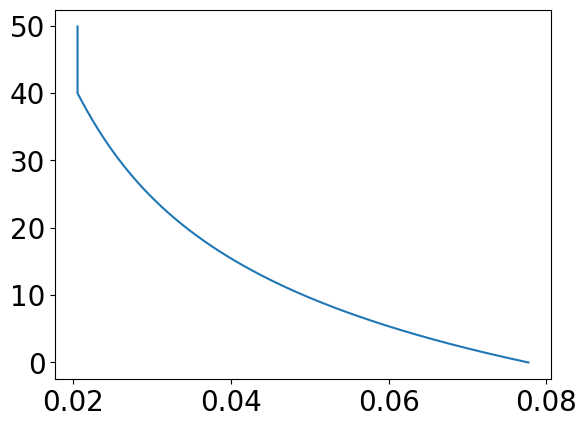

In [57]:
#print(dataset['RFM']['xCH4'])

fig,ax = plt.subplots()
ax.plot(dataset['RFM']['xCH4'],dataset['RFM']['z']/1e3)